In [2]:
# Using a basic network in Nengo, test gain and amplitude scaling

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np

def generate(scale=1, weights=None, seed=0):
    with nengo.Network(seed=seed) as net:
        input = nengo.Node(lambda t: t)
        output = nengo.Node(size_in=1)
        ens = nengo.Ensemble(
            n_neurons=100, dimensions=1,
            neuron_type=nengo.RectifiedLinear(amplitude=1/scale),
            bias=nengo.dists.Choice([0]),
            gain=nengo.dists.Choice([scale])
        )
        nengo.Connection(input, ens)
        if weights is not None:
            net.conn = nengo.Connection(ens.neurons, output, transform=weights)
        else:
            net.conn = nengo.Connection(ens, output)
        net.probe = nengo.Probe(output)
    return net

seed = np.random.randint(1e5)
print('seed: ', seed)

time = 1
net_noscale = generate(seed=seed)
with nengo.Simulator(net_noscale) as sim_noscale:
    sim_noscale.run(time)
    data_noscale = sim_noscale.data[net_noscale.probe]
    weights = sim_noscale.signals[sim_noscale.model.sig[net_noscale.conn]['weights']]

net_scale = generate(scale=100, weights=weights, seed=seed)
with nengo.Simulator(net_scale) as sim_scale:
    sim_scale.run(time)
    data_scale = sim_scale.data[net_scale.probe]

plt.plot(data_noscale)
plt.plot(data_scale)

sim_scale.close()

seed:  64183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/home/wolf/Dropbox/code/nengo_dl/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:00                                               
Train on 900 samples
900/900 [==============================] - 2s 2ms/sample - loss: 9648887.0742 - probe_loss: 9648889.0000
Train on 900 samples
900/900 [==============================] - 3s 3ms/sample - loss: 25.8907 - probe_loss: 25.8907
Train on 900 samples
900/900 [==============================] - 2s 3ms/sample - loss: 27.4901 - probe_loss: 27.4900
(100, 1, 20)


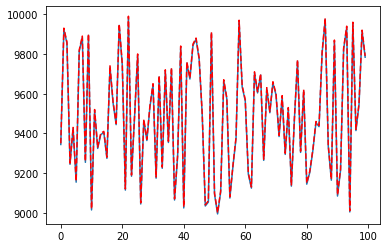

In [3]:
# Using a converted Keras network in NengoDL

import nengo_dl
import tensorflow as tf

input = tf.keras.Input(shape=(1))
relu1 = tf.keras.layers.Activation(tf.nn.relu)(input)
relu2 = tf.keras.layers.Activation(tf.nn.relu)(relu1)
flatten = tf.keras.layers.Flatten()(relu2)
dense2 = tf.keras.layers.Dense(units=20, use_bias=False)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense2)
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense2]

nengo_relu2 = converter.layers[relu2]
nengo_relu2.ensemble.gain = nengo.dists.Choice([1])
with converter.net as net:
    net.config[nengo_relu2.ensemble.neurons].trainable = False
    
with nengo_dl.Simulator(net) as sim:
    def loss_func(y_true, y_pred):
        return (y_true - tf.reduce_sum(y_pred))**2
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={nengo_output: loss_func},
    )
    
    data_input = np.arange(0, 1000).reshape(1000, 1 , 1)
    train_size = int(data_input.shape[0] * .9)
    test_indices = np.random.permutation(range(train_size, data_input.shape[0]))
    for ii in range(3):
        indices = np.random.permutation(range(train_size))
        sim.fit(
            {nengo_input: data_input[indices]},
            {nengo_output: data_input[indices] * 10},
            epochs=1,
        )
    sim.save_params('params')
    
    data = sim.predict({nengo_input: data_input[test_indices]})

print(data[nengo_output].shape)
plt.plot(np.sum(data[nengo_output], axis=2).squeeze())
plt.plot(np.sum(data_input[test_indices], axis=2).squeeze() * 10, 'r--')
    
sim.close()

(1, 3000, 1)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/home/wolf/Dropbox/code/nengo_dl/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:00                                               
(1, 3000, 20)


Text(0.5, 1.0, 'Rate neuron activity')

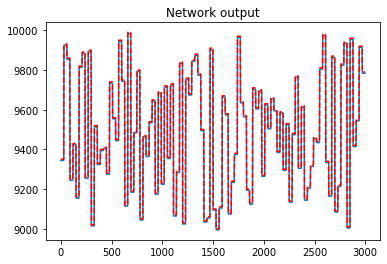

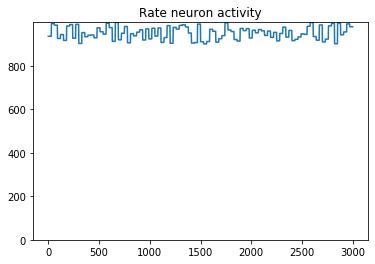

In [4]:
# get the activity plots of the rate mode neurons running on test set

converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()}
)

net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense2]
nengo_relu2 = converter.layers[relu2]

with net:
    probe_relu2 = nengo.Probe(nengo_relu2)

n_steps = 30  # number of time steps to repeat each input
test_data = data_input[test_indices].squeeze()
test_data = np.repeat(test_data, n_steps, axis=0)[np.newaxis, :, np.newaxis]

test_labels = (np.sum(data_input[test_indices], axis=2) * 10)
test_labels = np.repeat(test_labels, n_steps, axis=0)
    
print(test_data.shape)
with nengo_dl.Simulator(net, minibatch_size=1) as sim:
    sim.load_params('params')
    data = sim.predict({nengo_input: test_data})
    
print(data[nengo_output].shape)
plt.plot(np.sum(data[nengo_output], axis=2).squeeze())
plt.plot(test_labels, 'r--')
plt.title('Network output')
    
sim.close()

plt.figure()
plt.plot(data[probe_relu2].squeeze())
plt.ylim(0, np.max(data[probe_relu2]))
plt.title('Rate neuron activity')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
(1, 3000, 20)
Number of neurons:  1


Text(0.5, 1.0, 'Spiking neuron activity')

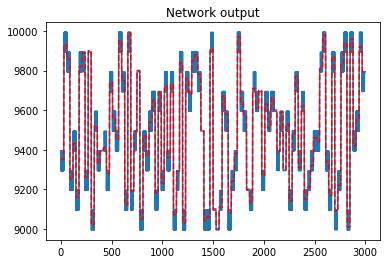

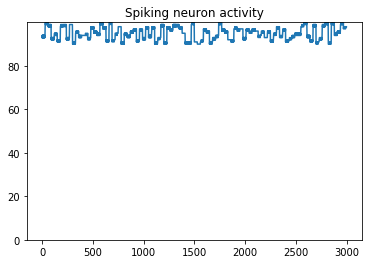

In [5]:
gain_scale = 100

converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
    scale_firing_rates=gain_scale,
)

net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense2]
nengo_relu2 = converter.layers[relu2]

with net:
    probe_relu2 = nengo.Probe(nengo_relu2)

with nengo_dl.Simulator(net) as sim:
    sim.load_params('params')
    data = sim.predict({nengo_input: test_data})
    
print(data[nengo_output].shape)
plt.plot(np.sum(data[nengo_output], axis=2).squeeze())
plt.plot(test_labels, 'r--')
plt.title('Network output')
    
sim.close()

plt.figure()
print('Number of neurons: ', nengo_relu2.ensemble.n_neurons)
plt.plot(data[probe_relu2].squeeze() * 0.001 * gain_scale)
plt.ylim(0, np.max(data[probe_relu2]) * 0.001 * gain_scale)
plt.title('Spiking neuron activity')

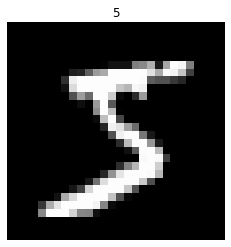

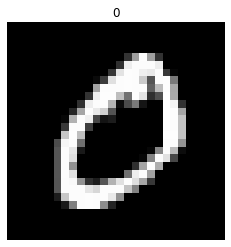

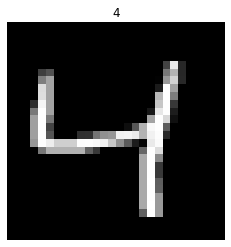

In [15]:
# load in MNIST dataset for testing convnets

%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

def load_mnist(plot=False):
    (train_images, train_labels), (test_images, test_labels) = (
        tf.keras.datasets.mnist.load_data())

    # flatten images
    train_images = train_images.reshape((train_images.shape[0], -1))
    test_images = test_images.reshape((test_images.shape[0], -1))

    if plot:
        for i in range(3):
            plt.figure()
            plt.imshow(np.reshape(train_images[i], (28, 28)),
                       cmap="gray")
            plt.axis('off')
            plt.title(str(train_labels[i]));

    # add single timestep to training data
    train_images = train_images[:, None, :]
    train_labels = train_labels[:, None, None]

    # when testing our network with spiking neurons we will need to run it
    # over time, so we repeat the input/target data for a number of timesteps.
    n_steps = 30
    test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
    test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

    return train_images, train_labels, test_images, test_labels

minibatch_size = 200
train_images, train_labels, test_images, test_labels = load_mnist(plot=True)

In [19]:
# Using a converted ConvNet Keras network in NengoDL

tf.random.set_seed(0)
input = tf.keras.Input(shape=(28, 28, 1), batch_size=minibatch_size)

conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    use_bias=False,
    activation=tf.nn.relu,
)(input)

flatten = tf.keras.layers.Flatten()(conv1)

dense1 = tf.keras.layers.Dense(units=10, use_bias=False)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense1)

In [44]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]
nengo_conv1 = converter.layers[conv1]

#nengo_conv1.ensemble.gain = nengo.dists.Choice([1])
with converter.net as net:
    #net.config[nengo_conv1.ensemble.neurons].trainable = False
    probe_conv1 = nengo.Probe(nengo_conv1, label='probe_conv1')
    
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0)

def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

def put_in_range(
        x, y, weight=100.0, min=200, max=300):
    assert len(y.shape) == 3
    index_greater = (y > max)
    index_lesser = (y < min)
    error = tf.reduce_sum(y[index_greater] - max) + tf.reduce_sum(min - y[index_lesser])
    return weight * error

#sim.compile(loss={nengo_output: classification_accuracy})
#print("accuracy before training:",
#      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={
        nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        #probe_conv1: put_in_range
    }
)
sim.fit(train_images, {nengo_output: train_labels, 
                       #probe_conv1: np.zeros(train_labels.shape)
                      },
        epochs=10)

# save the parameters to file
sim.save_params("mnist_params")

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy after training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])
    
sim.close()

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 103s 2ms/sample - loss: 3.1183 - probe_loss: 3.1183
Epoch 2/10
60000/60000 [==============================] - 102s 2ms/sample - loss: 0.0708 - probe_loss: 0.0708
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 0.0339 - probe_loss: 0.0339
Epoch 4/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 0.0176 - probe_loss: 0.0176
Epoch 5/10
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.0090 - probe_loss: 0.0090
Epoch 6/10
60000/60000 [==============================] - 107s 2ms/sample - loss: 0.0058 - probe_loss: 0.0058
Epoch 7/10
60000/60000 [==============================] - 102s 2ms/sample - loss: 0.0034 - probe_loss: 0.0034
Epoch 8/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 0.0024 - probe_loss: 0.0024
Epoch 9/10
60000/60000 [==============================] - 100s 2ms/sample - loss: 0.0013 - probe_l

accuracy after training: 0.9758000028133392


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


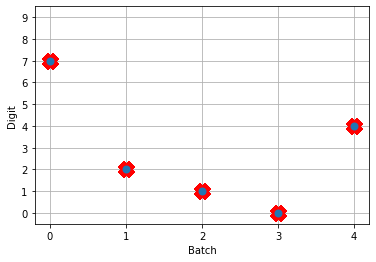

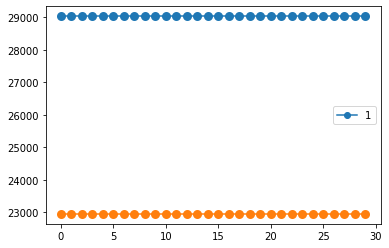

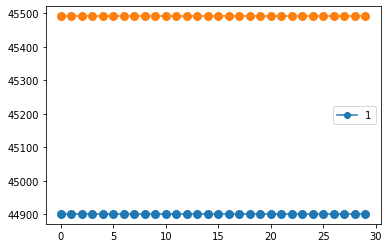

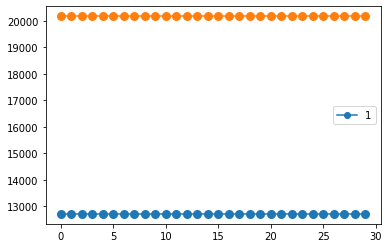

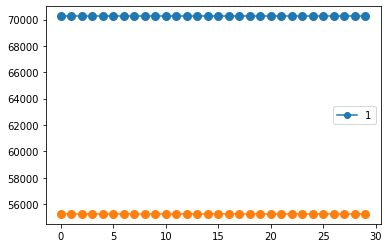

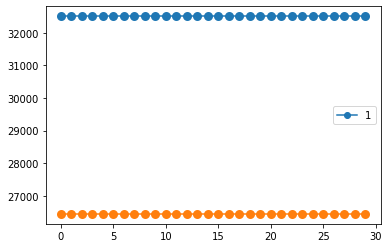

In [33]:
# test gain scaling with non-spiking neurons

gain_scales = [1]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
        scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_conv1 = converter.layers[conv1]
    
    with net:
        probe_conv1 = nengo.Probe(nengo_conv1)

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params_with_fr_loss")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})

    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
    plt.plot(np.argmax(data[nengo_output][:, ii], axis=1), 'o', mew=2)
    plt.grid()
    plt.ylabel('Digit')
    plt.xlabel('Batch')
    plt.ylim([-.5, 9.5])
    plt.xticks(range(5), range(5))
    plt.yticks(range(10), range(10))

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, :, :2], marker=markers[jj], mew=3)
    
    sim.close()

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

Number of neurons:  21632
Max value:  468.0984


Text(0.5, 1.0, 'Rate neuron activity')

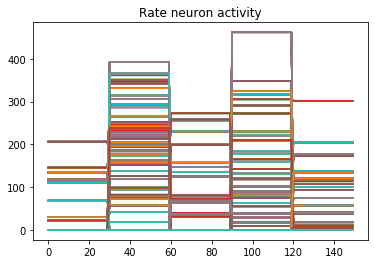

In [34]:
plt.figure()
n_neurons = 5000
n_images = 5
n_timesteps = 30
print('Number of neurons: ', nengo_conv1.ensemble.n_neurons)
print('Max value: ', np.max(data[probe_conv1].flatten()))
plt.plot(data[probe_conv1][:, :, :n_neurons].reshape(-1, n_neurons))
plt.title('Rate neuron activity')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)


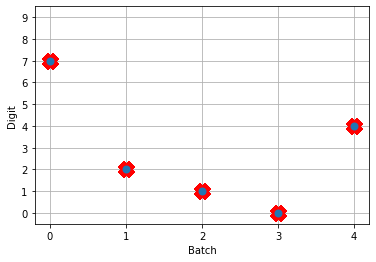

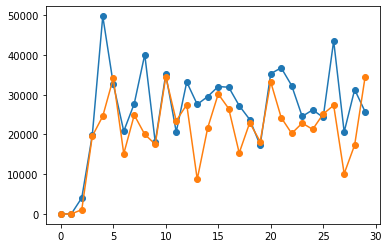

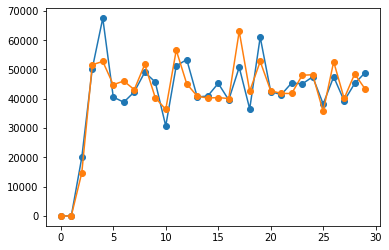

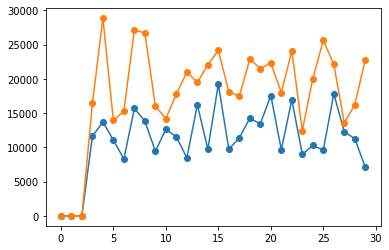

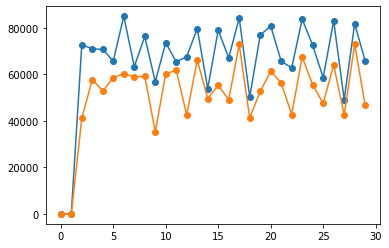

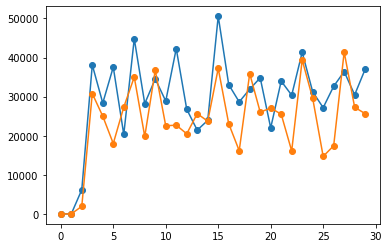

In [35]:
# test gain scaling with spiking neurons

gain_scales = [1]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
        scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_conv1 = converter.layers[conv1]
    
    with net:
        probe_conv1 = nengo.Probe(nengo_conv1)

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params_with_fr_loss")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})
    print(test_images.shape)
    print(test_labels.shape)

    print(data[nengo_output].shape)
    plt.figure()
    #plt.subplot(1, len(gain_scales), jj+1)
    plt.plot(test_labels[:n_test].squeeze(), 'rx', mew=15)
    plt.plot(np.argmax(data[nengo_output][:, -1], axis=1), 'o', mew=2)
    plt.grid()
    plt.ylabel('Digit')
    plt.xlabel('Batch')
    plt.ylim([-.5, 9.5])
    plt.xticks(range(5), range(5))
    plt.yticks(range(10), range(10))

    for ii in range(data[nengo_output].shape[0]):
        plt.figure()
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, :, :2], marker=markers[jj])

    sim.close()
    
# make the legends 
#from matplotlib.lines import Line2D
#custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

#for jj in range(data[nengo_output].shape[0]):
#    plt.figure(jj+1)
#    plt.legend(custom_lines, gain_scales)

Number of neurons:  21632
Max value:  1.0
(5, 30, 3000)


Text(0.5, 1.0, 'Spiking neuron activity')

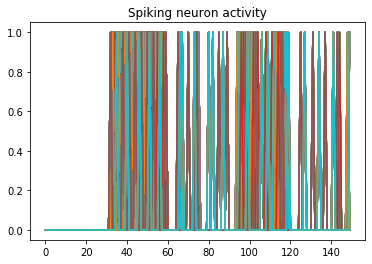

In [36]:
n_neurons = 3000
n_images = 5
n_timesteps = 30
print('Number of neurons: ', nengo_conv1.ensemble.n_neurons)
print('Max value: ', np.max(data[probe_conv1].flatten() * 0.001 * gain_scale))
print(data[probe_conv1][:,:,:n_neurons].shape)
plt.plot(data[probe_conv1][:, :, :n_neurons].reshape(-1, n_neurons) * 0.001 * gain_scale)
#plt.ylim(0, np.max(data[probe_conv1]) * 0.001 / gain_scale)
plt.title('Spiking neuron activity')

In [12]:
# Using a converted ConvNet Keras network with a ReLU input layer in NengoDL

tf.random.set_seed(0)
input = tf.keras.Input(shape=(28, 28, 1), batch_size=minibatch_size)

relu1 = tf.keras.layers.Activation(tf.nn.relu)(input)

conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    use_bias=False,
    activation=tf.nn.relu,
    data_format="channels_last"
)(relu1)

flatten = tf.keras.layers.Flatten()(conv1)

dense1 = tf.keras.layers.Dense(units=10, use_bias=False)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense1)

In [ ]:
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense1]
nengo_relu1 = converter.layers[relu1]
nengo_conv1 = converter.layers[conv1]

nengo_relu1.ensemble.gain = nengo.dists.Choice([1])
nengo_conv1.ensemble.gain = nengo.dists.Choice([1])
with converter.net as net:
    net.config[nengo_relu1.ensemble.neurons].trainable = False
    net.config[nengo_conv1.ensemble.neurons].trainable = False
    probe_relu1 = nengo.Probe(nengo_relu1)
    probe_conv1 = nengo.Probe(nengo_conv1)
    
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0)

def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

def put_in_range(
        x, y, weight=1.0, min=200, max=300):
    assert len(y.shape) == 3
    index_greater = (y > max)
    index_lesser = (y < min)
    error = tf.reduce_sum(y[index_greater] - max) + tf.reduce_sum(min - y[index_lesser])
    return weight * error

#sim.compile(loss={nengo_output: classification_accuracy})
#print("accuracy before training:",
#      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={
        nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        probe_relu1: put_in_range,
        probe_conv1: put_in_range,
    }
)
sim.fit(train_images, {nengo_output: train_labels, 
                       probe_relu1: np.zeros(train_labels.shape),
                       probe_conv1: np.zeros(train_labels.shape)}, epochs=10)

# save the parameters to file
sim.save_params("mnist_params")

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy after training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])
    
sim.close()

In [ ]:
# test gain scaling with non-spiking neurons
import nengo_dl

gain_scales = [10, 50, 1000]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
        scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_relu1 = converter.layers[relu1]
    nengo_conv1 = converter.layers[conv1]
    
    with net:
        probe_relu1 = nengo.Probe(nengo_relu1)
        probe_conv1 = nengo.Probe(nengo_conv1)

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})

    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, ::5, :2], marker=markers[jj])
    
    sim.close()

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

In [ ]:
plt.figure()
n_neurons = 5000
n_images = 5
n_timesteps = 30
print('Number of neurons: ', nengo_conv1.ensemble.n_neurons)
print('Max value: ', np.max(data[probe_conv1].flatten()))
plt.plot(data[probe_conv1][:, :, n_neurons:n_neurons*2].reshape(n_images * n_timesteps, -1))
plt.title('Rate neuron activity')

In [ ]:
# test gain scaling with spiking neurons

gain_scales = [1, 10, 20]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
        scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_relu1 = converter.layers[relu1]
    nengo_conv1 = converter.layers[conv1]
    
    with net:
        probe_relu1 = nengo.Probe(nengo_relu1)
        probe_conv1 = nengo.Probe(nengo_conv1)
    
    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]}, stateful=False)

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, :, :2], marker=markers[jj])
    sim.close()

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

In [ ]:
plt.figure()
n_neurons = 3000
n_images = 5
n_timesteps = 30
print('Number of neurons: ', nengo_conv1.ensemble.n_neurons)
print('Max value: ', np.max(data[probe_conv1].flatten()))
plt.plot(data[probe_conv1][:, :, :n_neurons].reshape(
    n_images * n_timesteps, -1))
#plt.ylim(0, np.max(data[probe_conv1]) * 0.001 / gain_scale)
plt.title('Spiking neuron activity')

In [ ]:
# load up the rover network and test with rate neurons
import nengo_dl
import tensorflow as tf

minibatch_size = 2

tf.random.set_seed(0)
input = tf.keras.Input(shape=(32, 128, 3), batch_size=minibatch_size)

relu1 = tf.keras.layers.Activation(tf.nn.relu)(input)

conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    use_bias=False,
    activation=tf.nn.relu,
    data_format="channels_last"
)(relu1)

flatten = tf.keras.layers.Flatten()(conv1)

dense1 = tf.keras.layers.Dense(units=2, use_bias=False)(flatten)

model = tf.keras.Model(inputs=input, outputs=dense1)

In [ ]:
import matplotlib.pyplot as plt
import nengo 
import numpy as np

import dl_utils

gain_scales = [1, 5, 10]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):
    
    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
        scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_relu1 = converter.layers[relu1]
    nengo_conv1 = converter.layers[conv1]
    
    with net:
        probe_relu1 = nengo.Probe(nengo_relu1)
        probe_conv1 = nengo.Probe(nengo_conv1)    

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("data/rover_training_0004/test/test_1/epoch_73")
    n_test = 2
    
    processed_data = np.load('/home/tdewolf/Downloads/validation_images_processed.npz')
    validation_images = processed_data['images']
    validation_images = dl_utils.repeat_data(
        data=validation_images, batch_data=False, n_steps=30)
    validation_targets = processed_data['targets']
    validation_targets = dl_utils.repeat_data(
        data=validation_targets, batch_data=False, n_steps=30)
    
    print('validation_images shape: ', validation_images.shape)
    
    data = sim.predict({nengo_input: validation_images})#[:n_test]})

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(validation_targets[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        #plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, :, :2], marker=markers[jj])
    
    sim.close()

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

In [ ]:
print(data[probe_conv1].shape)
plt.plot(data[probe_conv1].squeeze()[:])

In [ ]:
import matplotlib.pyplot as plt
import nengo 
import numpy as np
from nengo.utils.matplotlib import rasterplot
import nengo_loihi

import dl_utils

weights = []
gain_scales = [100]
markers = ['o', '^', 'x', '.', '3']
lines = []
for jj, gain_scale in enumerate(gain_scales):
    
    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
        #scale_firing_rates=gain_scale,
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense1]
    nengo_relu1 = converter.layers[relu1]
    nengo_conv1 = converter.layers[conv1]
    
    # setting up the scaling and gain here to be able to control it for each layer
    nengo_relu1.ensemble.neuron_type = nengo.SpikingRectifiedLinear(amplitude=1/100)
    nengo_relu1.ensemble.gain = nengo.dists.Choice([100])
    nengo_conv1.ensemble.neuron_type = nengo.SpikingRectifiedLinear(amplitude=1/200)
    nengo_conv1.ensemble.gain = nengo.dists.Choice([200])
    
    with net:
        probe_relu1 = nengo.Probe(nengo_relu1)
        probe_conv1 = nengo.Probe(nengo_conv1)
        probe_output = nengo.Probe(converter.layers[dense1], synapse=0.005)
        
    # set our synapses
#     for cc, conn in enumerate(net.all_connections):
#         conn.synapse = 0.001
        
    with nengo_dl.Simulator(net, minibatch_size=1, seed=0, dt=0.001) as sim:
        sim.load_params("data/rover_training_0004/test/test_1/epoch_41")

        n_test = 5

        processed_data = np.load('/home/tdewolf/Downloads/validation_images_processed.npz')
        validation_images = processed_data['images']
        validation_images = dl_utils.repeat_data(
            data=validation_images, batch_data=False, n_steps=30)
        validation_targets = processed_data['targets']
        validation_targets = dl_utils.repeat_data(
            data=validation_targets, batch_data=False, n_steps=30)

        data = sim.predict({nengo_input: validation_images[:n_test]})

        print(data[probe_output].shape)
        plt.figure(0, figsize=(10, 5))
        plt.subplot(1, len(gain_scales), jj+1)
        for ii in range(data[probe_output].shape[1]):
            plt.plot(np.argmax(data[probe_output][:, ii], axis=1))
        plt.plot(validation_targets[:n_test, :, :2].squeeze(), 'r--')

        for ii in range(data[probe_output].shape[0]):
            #plt.figure(ii+1, figsize=(10, 5))
            plt.gca().set_prop_cycle(None)
            plt.subplot(1, len(gain_scales), jj+1)
            plt.plot(data[probe_output][ii, :, :2], marker=markers[jj])
            
        plt.figure(figsize=(10, 5))
        plt.plot(np.sum((data[probe_relu1].squeeze() > 0), axis=1))

        # save the weights from the network
        for key in sim.data.keys():
            if 'Connection' in str(key):
                weights.append(np.copy(sim.data[key].weights))
                
        print(data[probe_relu1].shape)

        dl_utils.plot_neuron_activity(
            activity=data[probe_relu1],
            num_pts=300,
            save_folder='.',
            save_name='raster',
            num_neurons_to_plot=100,
            images=None,
        )

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[probe_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

In [ ]:
plt.plot(data[probe_relu1].squeeze()[:, :1000] * 0.001 * 100)

In [ ]:
print(np.max(data[probe_relu1].squeeze() * gain_scale * 0.001))